In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from notebooks.backtesting_utils import get_aroon

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="MSFT"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_aroon = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

period = 14
df_aroon, df_crossovers = get_aroon(df_aroon, period)


In [4]:
df_aroon.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,periods_since_hh,periods_since_ll,aroon_up,aroon_down,position,returns,strategy
date_reference,,,,,,,,,,,,,
2025-10-20,MSFT,516.79,518.700,513.43,514.61,14665620,10.0,4.0,28.571429,71.428571,-1,0.006231,0.006231
2025-10-21,MSFT,517.66,518.690,513.04,517.50,15586204,11.0,5.0,21.428571,64.285714,1,0.001682,-0.001682
2025-10-22,MSFT,520.54,525.230,517.71,521.15,18962694,12.0,6.0,14.285714,57.142857,1,0.005548,0.005548
2025-10-23,MSFT,520.56,523.950,518.61,522.46,14023532,13.0,7.0,7.142857,50.000000,1,0.000038,0.000038
2025-10-24,MSFT,523.61,525.345,520.71,522.79,15532360,13.0,8.0,7.142857,42.857143,1,0.005842,0.005842


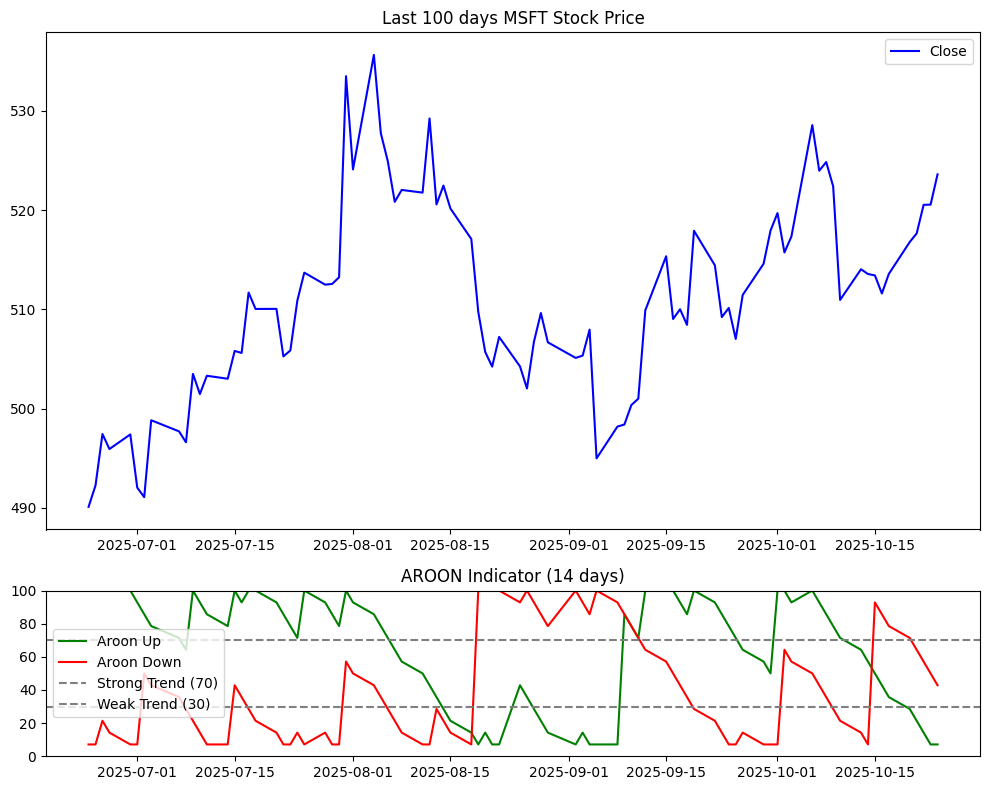

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_aroon.index, df_aroon['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: AROON plot
axs[1].plot(df_aroon.index, df_aroon['aroon_up'], label='Aroon Up', color='green')
axs[1].plot(df_aroon.index, df_aroon['aroon_down'], label='Aroon Down', color='red')
axs[1].axhline(70, color='gray', linestyle='--', label='Strong Trend (70)')
axs[1].axhline(30, color='gray', linestyle='--', label='Weak Trend (30)')
axs[1].set_title(f"AROON Indicator ({period} days)")
axs[1].legend()
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

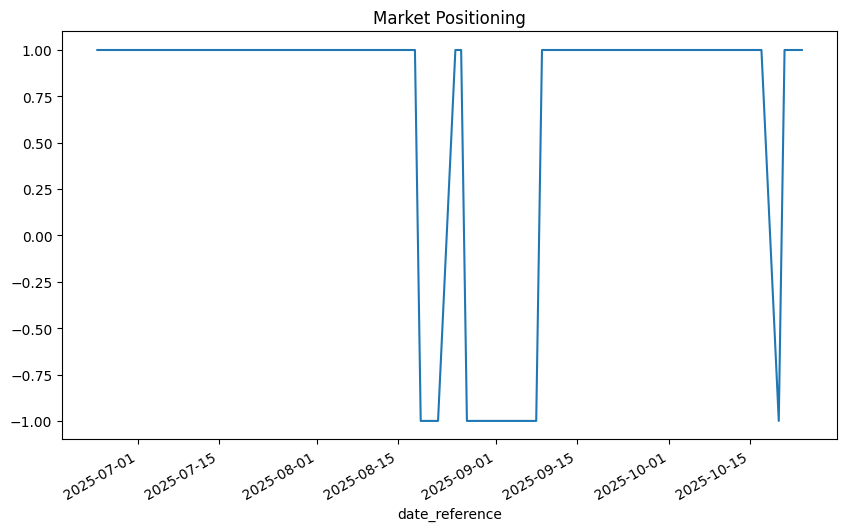

In [6]:
df_aroon['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_aroon[['returns', 'strategy']].sum().apply(np.exp)

returns     1.077387
strategy    1.134350
dtype: float64

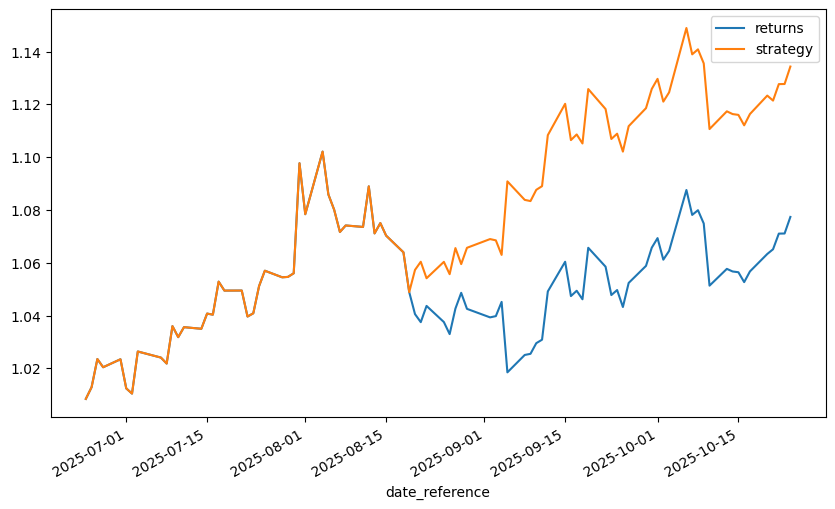

In [8]:
df_aroon[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_crossovers[['val_close', 'aroon_up', 'aroon_down', 'position']]

,val_close,aroon_up,aroon_down,position
date_reference,,,,
2025-08-19,509.77,7.142857,100.000000,-1
2025-08-25,504.26,42.857143,92.857143,1
2025-08-27,506.74,28.571429,92.857143,-1
2025-09-09,498.41,85.714286,85.714286,1
2025-10-20,516.79,28.571429,71.428571,-1
2025-10-21,517.66,21.428571,64.285714,1
